### FRAUD DETECTION IN FINANTIAL TRANSACTIONS USING ANOMALY DETECTION WITH AUTOENCODER NETWORKS AND RANDOM FOREST MODEL BY CAIO QUINAMO

#### IMPORT NECESSARY LIBRARIES

In [3]:
import pandas as pd
import numpy as np

from IPython.display import HTML, display
from scipy import stats, spatial

import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns

from sklearn import manifold
from sklearn import decomposition
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import pipeline
from sklearn import feature_selection
from sklearn import ensemble
from sklearn import metrics

import tensorflow as tf
from tensorflow import keras

import warnings
import random

np.random.seed(4)
sns.set_style('dark')
warnings.simplefilter(action='ignore', category=FutureWarning)

#### ABOUT DATA

In [5]:
rawdata = pd.read_csv('Dataset NDSPP.2025.0001.01.1.csv')
data = rawdata.copy(deep=False)
data0, data1 = data[data['Class'] == 0], data[data['Class'] == 1]

In [6]:
# General Info
display(HTML("<h3 style=font-weight:bold; '>Data Info</h3>"))
print(data.info(verbose=False))

display(HTML("<h3 style=font-weight:bold; '>Duplicated Records</h3>"), data.duplicated().sum())
display(HTML("<h4 style=font-weight:bold; '>Data 0. Duplicated Records</h4>"), data0.duplicated().sum())

if data0.duplicated().sum() == 0:
    display(HTML("<h5 style=font-weight:bold; '>No duplicated records found</h5>"))
else:
    data0 = data0.drop_duplicates().reset_index(drop=True)
    display(HTML("<h5 style=font-weight:bold; '>Duplicated records removed successfully</h5>"))
display(HTML("<h4 style=font-weight:bold; '>Data 1. Duplicated Records</h4>"), data1.duplicated().sum())
display(HTML("<h5 style=font-weight:bold; '>Duplicated records will not be removed</h5>"))

display(HTML("<h3 style=font-weight:bold; '>Missing Values</h3>"))
nullcolumns = data.isnull().sum()[data.isnull().sum() > 0]
if nullcolumns.empty:
    display(HTML("<h5 style=font-weight:bold; '>No missing values were found</h5>"))
else:
    display(HTML("<h5 style=font-weight:bold; '>Missing values found in the following columns:</h5>"))
    print(nullcolumns)

data0 = data0.reset_index(drop=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Columns: 31 entries, Time to Class
dtypes: float64(30), int64(1)
memory usage: 67.4 MB
None


1081

1062

19

##### 1. ANALYSIS OF THE TARGET VARIABLE

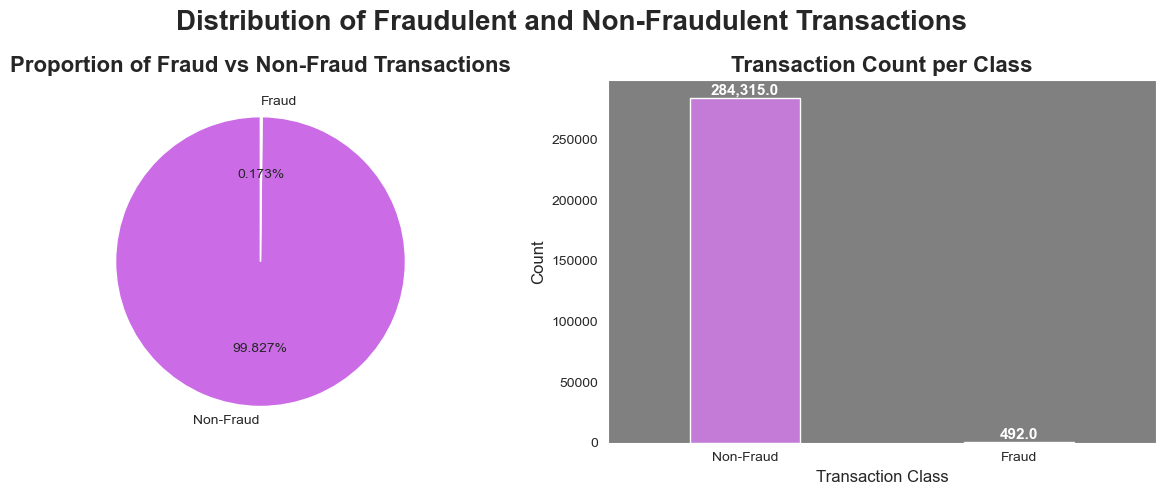

In [8]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
classdist = {'Non-Fraud': len(data0), 'Fraud': len(data1)}
x = ['Fraud' if val == 1 else 'Non-Fraud' for val in data['Class']]

axs[0].pie(x=list(classdist.values()), labels=list(classdist.keys()), colors=['#CB6CE6', 'white'], autopct='%1.3f%%', startangle=90)
axs[0].set_title('Proportion of Fraud vs Non-Fraud Transactions', fontsize=16, fontweight='bold')

sns.countplot(data=data, x=x, width=0.4, palette=['#CB6CE6', 'white'], ax=axs[1])
axs[1].set_title('Transaction Count per Class', fontsize=16, fontweight='bold'), axs[1].set_facecolor('grey')
axs[1].set_xlabel('Transaction Class', fontsize=12), axs[1].set_ylabel('Count', fontsize=12)

for p in axs[1].patches:
    height = p.get_height()
    axs[1].annotate(f'{height:,}', 
                    (p.get_x() + p.get_width() / 2, height), 
                    ha='center', va='bottom', fontsize=11, fontweight='bold', color='w')

plt.suptitle('Distribution of Fraudulent and Non-Fraudulent Transactions', fontsize=20, fontweight='bold'), plt.tight_layout();

  Como era de esperar y como ya se anunciaba en la descripción del conjunto de datos, las clases están extremadamente desbalanceadas, hay apenas 492 entradas para la clase positiva y 284315 entradas para la clase negativa. Lo que se traduce en que el 99.827% de los datos son trasacciones verídicas y apenas el 0.173% de las transacciones son transacciones clasificadas como fraudulentas.

##### 2. CORRELATIONS WITH THE TARGET VARIABLE

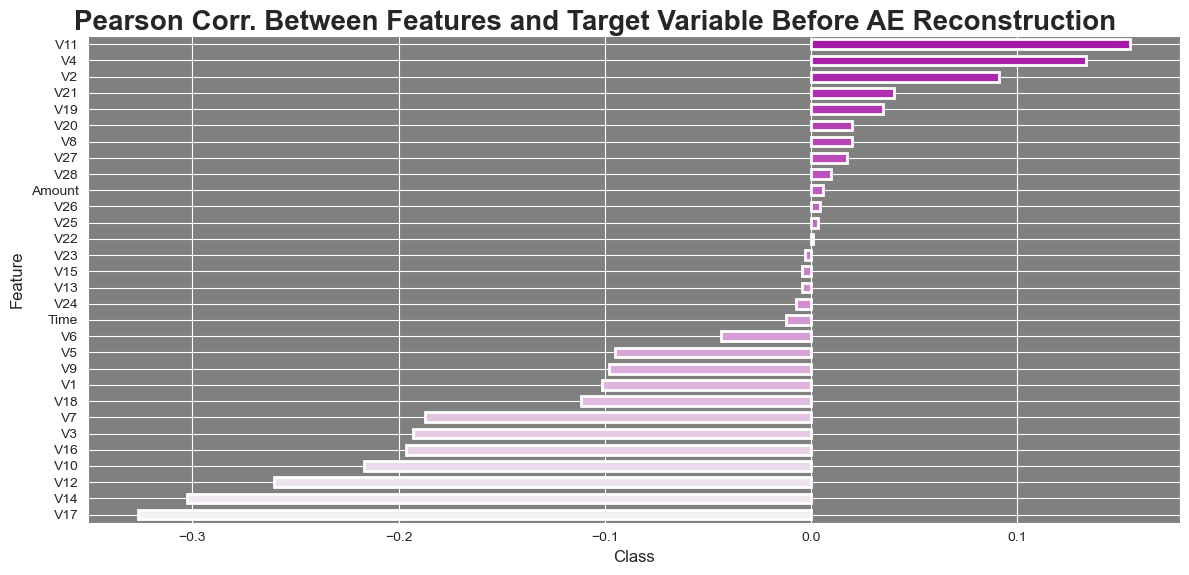

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))
corr = data.corr()['Class'].drop('Class').sort_values(ascending=False).reset_index()

sns.barplot(data=corr, x='Class', y='index', width=0.6, palette='light:m_r', edgecolor='white', linewidth=2, ax=ax)

plt.xlabel('Class', fontsize=12), plt.ylabel('Feature', fontsize=12), ax.set_facecolor('grey'), plt.grid()
plt.suptitle('Pearson Corr. Between Features and Target Variable Before AE Reconstruction', fontsize=20, fontweight='bold', y=0.95)
plt.tight_layout();

La gráfica representa un resultado esperado, ya que los datos del conjunto han sido descompuestos mediante Principal Component Analysis, entonces ya era de esperar que las correlaciones mediante el método de Pearson serían medias-bajas en comparación con la variable objetivo, debido a que PCA transforma las variables originales en nuevas variables no correlacionadas (componentes principales) que son combinaciones lineales de las originales, estas están ordenadas por la cantidad de varianza explicada, las features no consideran la variable objetivo, ya que PCA es un método no supervisado, entonces es normal que no se considere la variable objetivo durante el proceso de descomposición. Como resultado los componentes generados maximizan la varianza de los datos originales, pero no necesariamente retienen la información más relevante para predecir la clase. La baja correlación no implica que los datos sean necesariamente inútiles, sino que simplemente reflejan la naturaleza del método de descomposición aplicado, que prioriza la estructura interna del conjunto de datos y no su relación con una etiqueta específica.

De todas maneras, se estará atento a las variables con mayor correlación, tanto positiva como negativa, ya que las variables más correlacionadas podrían explicar ciertos patrones de comportamiento, como por ejemplo observar si las variables con mayor cantidad de valores atípicos (univariados) tienen alguna representación o relación con las variables con mayor correlación.

Otro detalle curioso es que el valor monetario de la transacción tiene uno de los coeficientes de correlación más bajos con la variable objetivo, así como time, como estas dos son las únicas variables realmente con descripción sobre su representatividad, sería conveniente analizar su comportamiento.

V11, V04, V02, V21, V19 son las cinco variables con mayor correlación positiva con la variable objetivo.

V17, V14, V12, V10, V16 son las cinco variables con mayor correlación negativa con la varibale objetivo.

Las variables con mayor correlación negativa tienen un mayor coeficiente de correlación absoluta que las cinco variables con mayor coeficiente de correlación positiva con respecto a la variable objetivo.

##### 3. UNIVARIATE ANALYSIS OF TIME AND AMOUNT

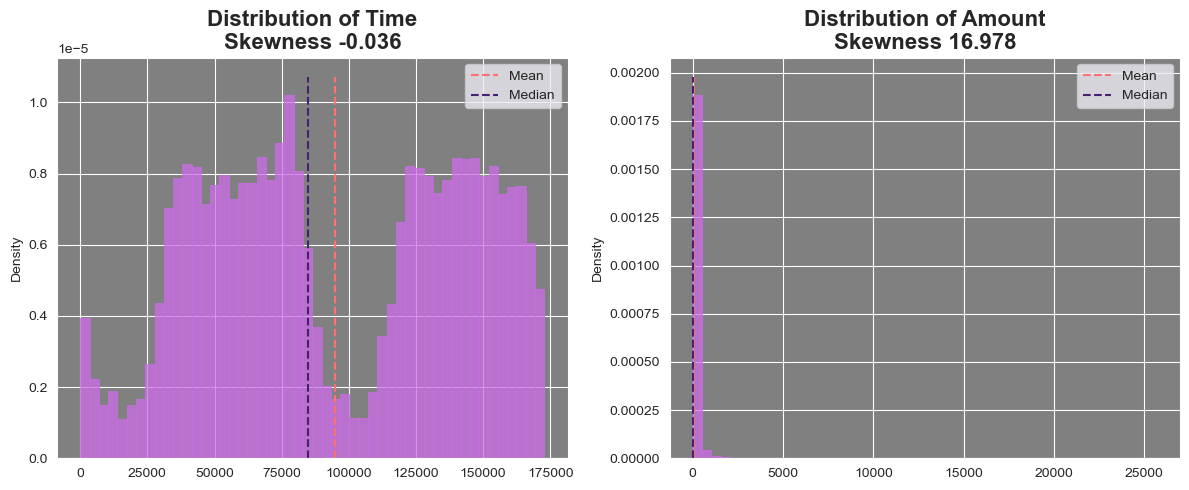

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

for i, (col, ax) in enumerate(zip(data[['Time', 'Amount']].columns, axs.flat)):
    sns.histplot(data[col], bins=50, stat='density', edgecolor='#CB6CE6', color='#CB6CE6', ax=ax)
    ax.set_title(f'Distribution of {col}\nSkewness {data[col].skew():.3f}', fontsize=16, fontweight='bold')
    ax.set_xlabel(None), ax.set_ylabel('Density', fontsize=10)
    
    ymin, ymax = ax.get_ylim()
    
    ax.vlines(x=data[col].mean(),   ymin=ymin, ymax=ymax, linestyles='--', colors='#FF7070', label='Mean')
    ax.vlines(x=data[col].median(), ymin=ymin, ymax=ymax, linestyles='--', colors='#482071', label='Median')
    ax.set_facecolor('grey'), ax.grid(), ax.legend()
    
plt.tight_layout();

**«Time»** muestra una distribución relativamente simétrica (skewness ≈ -0.036), lo que indica que no presenta una asimetría significativa. Sin embargo, al tratarse de una variable que simplemente refleja el número de segundos desde la primera transacción registrada, carece de interpretabilidad directa en términos de comportamiento transaccional. Se evaluará si su inclusión aporta valor real al modelo o si es preferible eliminarla para evitar ruido.

**«Amount»**, en contraste, presenta una asimetría positiva extrema (skewness ≈ 16.978). La mayoría de las transacciones se agrupan en valores bajos, mientras que solo una minoría corresponde a montos elevados. Esta fuerte asimetría podría introducir sesgos en el modelo y afectar negativamente el proceso de aprendizaje. Por ello, previo al entrenamiento del autoencoder, se aplicará una transformación adecuada a las features para reducir el impacto de los valores atípicos. Además, ya contamos con dos señales (el coeficiente de Pearson y el coeficiente de asimetría) que sugieren que, en general, las transacciones fraudulentas tienden a no implicar montos elevados.

In [16]:
quantiles = [0.01, 0.50, 0.99]
summary = data1[['Amount', 'Time']].describe(quantiles)
summary.columns = summary.rename(columns={'Amount': 'Amount (Class 1)', 'Time': 'Time (Class 1)'}).columns
summary['Amount (Class 0)'], summary['Time (Class 0)'] = data0['Amount'].describe(quantiles), data0['Time'].describe(quantiles)
summary.loc['range'] = summary.loc['max'] - summary.loc['min']
style = summary.style.set_table_attributes('style="margin-left: auto; margin-right: auto;"')
display(HTML("<h3 style='font-weight:bold;' >Summary of Statistics for Amount and Time by Class</h3>"))
display(style)

,Amount (Class 1),Time (Class 1),Amount (Class 0),Time (Class 0)
count,492.000000,492.000000,283253.000000,283253.000000
mean,122.211321,80746.806911,88.413575,94835.058093
std,256.683288,47835.365138,250.379023,47475.550607
min,0.000000,406.000000,0.000000,0.000000
1%,0.000000,7525.370000,0.120000,2425.000000
50%,9.250000,75568.500000,22.000000,84711.000000
99%,1357.427900,167500.360000,1018.057600,170560.480000
max,2125.870000,170348.000000,25691.160000,172792.000000
range,2125.870000,169942.000000,25691.160000,172792.000000


In [17]:
statistics = {'Amount (Class 1)': summary['Amount (Class 1)'], 'Amount (Class 0)': summary['Amount (Class 0)'],
              'Time (Class 1)'  : summary['Time (Class 1)']  , 'Time (Class 0)'  : summary['Time (Class 0)']}
statistics = pd.DataFrame(statistics, index=['mean', '50%', 'std', 'range'])

amount = statistics[['Amount (Class 1)', 'Amount (Class 0)']].reset_index().melt(id_vars='index', value_name='Value')
time = statistics[['Time (Class 1)', 'Time (Class 0)']].reset_index().melt(id_vars='index', value_name='Value')
ranges = pd.concat([amount.loc[[3,7]].assign(Variable='Amount'), time.loc[[3,7]].assign(Variable='Time')]).reset_index(drop=True)

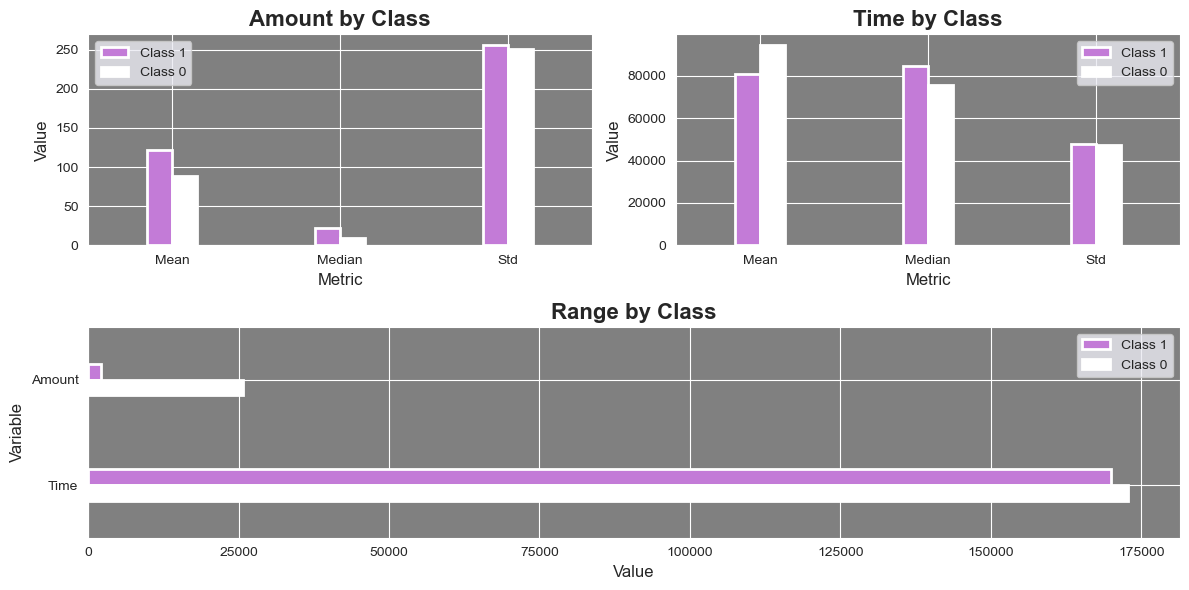

In [18]:
fig = plt.figure(figsize=(12, 6))
gs = gridspec.GridSpec(2, 2, figure=fig)
hue = ['Class 1','Class 0','Class 1','Class 0', 'Class 1','Class 0']

ax1 = fig.add_subplot(gs[0, 0])
sns.barplot(data=amount.drop([3, 7]), x='index', y='Value', hue=hue,
            width=0.3, edgecolor='white', linewidth=2, palette=['#CB6CE6', 'white'], ax=ax1)
ax1.set_title('Amount by Class', fontsize=16, fontweight='bold')
ax1.set_xticks([0, 1, 2]), ax1.set_xticklabels(['Mean', 'Median', 'Std'])
ax1.set_xlabel('Metric', fontsize=12), ax1.set_ylabel('Value', fontsize=12), ax1.set_facecolor('grey'), ax1.grid()

ax2 = fig.add_subplot(gs[0, 1])
sns.barplot(data=time.drop([3, 7]), x='index', y='Value', hue=hue,
            width=0.3, edgecolor='white', linewidth=2, palette=['#CB6CE6', 'white'], ax=ax2)
ax2.set_title('Time by Class', fontsize=16, fontweight='bold')
ax2.set_xticks([0, 1, 2]), ax2.set_xticklabels(['Mean', 'Median', 'Std'])
ax2.set_xlabel('Metric', fontsize=12), ax2.set_ylabel('Value', fontsize=12), ax2.set_facecolor('grey'), ax2.grid()

ax3 = fig.add_subplot(gs[1, :])
sns.barplot(data=ranges, x='Value', y='Variable', hue=['Class 1','Class 0','Class 1','Class 0'],
            width=0.3, edgecolor='white', linewidth=2, palette=['#CB6CE6', 'white'], ax=ax3)
ax3.set_title('Range by Class', fontsize=16, fontweight='bold')
ax3.set_xlabel('Value', fontsize=12), ax3.set_ylabel('Variable', fontsize=12), ax3.set_facecolor('grey'), ax3.grid()

plt.tight_layout();

**Amount:** Aunque la media en clase 1 es más alta, el 50% de las transacciones fraudulentas tienen montos menores a 9.25, lo que indica una fuerte asimetría. El valor máximo de una transacción no fraudulenta es más de 12 veces mayor que el de una transacción fraudulenta (≈25,691 vs. ≈2,126). En la clase 1, el percentil 99 (1357) es muy inferior al máximo (2125), lo que sugiere que los valores atípicos afectan significativamente la media.

**Time:** La media de Time es más baja en la clase 1, lo que podría indicar que los fraudes ocurren más frecuentemente al inicio del periodo registrado. El rango de Time es similar en ambas clases, pero la mediana en clase 1 (≈75,568) es algo menor que en clase 0 (≈84,711), lo que podría reflejar un patrón temporal en los intentos de fraude. Como criterio personal y debido a su baja representatividad, se ha decidido eliminar «Time» tanto del análisis como del modelo predictivo, al considerarse poco influyente en la detección de fraudes.

##### 4. 2-D DATA VISUALISATION (BEFORE PREPROCESSING AND AUTOENCODER RECONSTRUCTION)

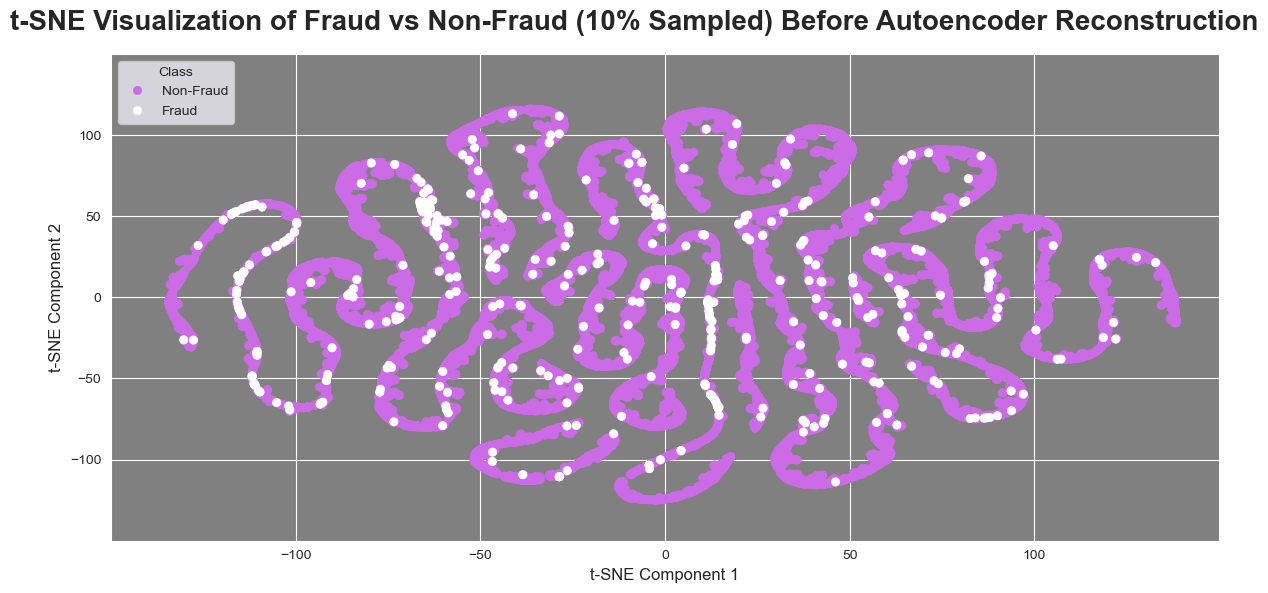

In [21]:
np.random.seed(4)
tsne = manifold.TSNE(n_components=2, random_state=4, n_jobs=-1)

fig, ax = plt.subplots(figsize=(12, 6))

plotdata0 = data0.iloc[np.random.choice(data0.shape[0], int(len(data0) * 0.10), replace=False)]
plotdata = pd.concat([plotdata0, data1], axis=0).reset_index(drop=True)
Xsampled, ysampled = plotdata.drop(['Class'], axis=1).values, plotdata["Class"].values

tsnebefore = tsne.fit_transform(Xsampled)
xtsnebefore, ytsnebefore = tsnebefore[:,0], tsnebefore[:,1]
huebefore = pd.Series(ysampled).replace({0:'Non-Fraud', 1:'Fraud'})

sns.scatterplot(x=xtsnebefore, y=ytsnebefore, hue=huebefore, palette=['#CB6CE6', 'white'], edgecolor=None)
plt.grid(), ax.set_facecolor('grey'), plt.legend(title='Class', loc='upper left')
plt.xlim(-150, 150), plt.xticks([-100, -50, 0, 50, 100]), plt.ylim(-150, 150), plt.yticks([-100, -50, 0, 50, 100])
plt.xlabel('t-SNE Component 1', fontsize=12), plt.ylabel('t-SNE Component 2', fontsize=12)
plt.suptitle('t-SNE Visualization of Fraud vs Non-Fraud (10% Sampled) Before Autoencoder Reconstruction',
             fontsize=20, fontweight='bold'), plt.tight_layout();

Gráfico t-SNE aplicado sobre una muestra del 10% del conjunto de datos original. En este gráfico, los puntos blancos representan transacciones fraudulentas, mientras que los puntos violeta indican transacciones legítimas. Aunque no se observa una separación evidente entre ambas clases, se pueden identificar ciertas zonas con concentración local de fraudes, lo que sugiere la presencia de patrones latentes. Esta visualización refuerza la decisión de utilizar un modelo autoencoder para generar una representación interna que facilite la separación entre clases en un espacio latente optimizado para detección de anomalías.

##### 5. UNIVARIATE OUTLIER DETECTION VIA Z-SCORE STANDARDIZATION

In [24]:
def zscores(data):
    data = data.select_dtypes(include='number')
    for col in data.columns:
        z_score = (data[col] - data[col].mean()) / data[col].std()
        data[f'{col} (Z-Score)'] = z_score
    return data

zscore = zscores(data)
zscore = zscore.iloc[:, zscore.shape[1] // 2:-1].reset_index(drop=True)
zscore['Class'] = data['Class']
zscore['Outlier'] = (zscore.drop('Class', axis=1).abs() > 3).any(axis=1).astype(int)

In [25]:
pca = decomposition.PCA(n_components=2, random_state=4)
Xpca = pca.fit_transform(zscore.drop(['Class', 'Outlier'], axis=1))
dfpca = pd.DataFrame(Xpca, columns=['PCA 1', 'PCA 2'])
dfpca['Outlier'] = zscore['Outlier']
dfpca['Class'] = data['Class']

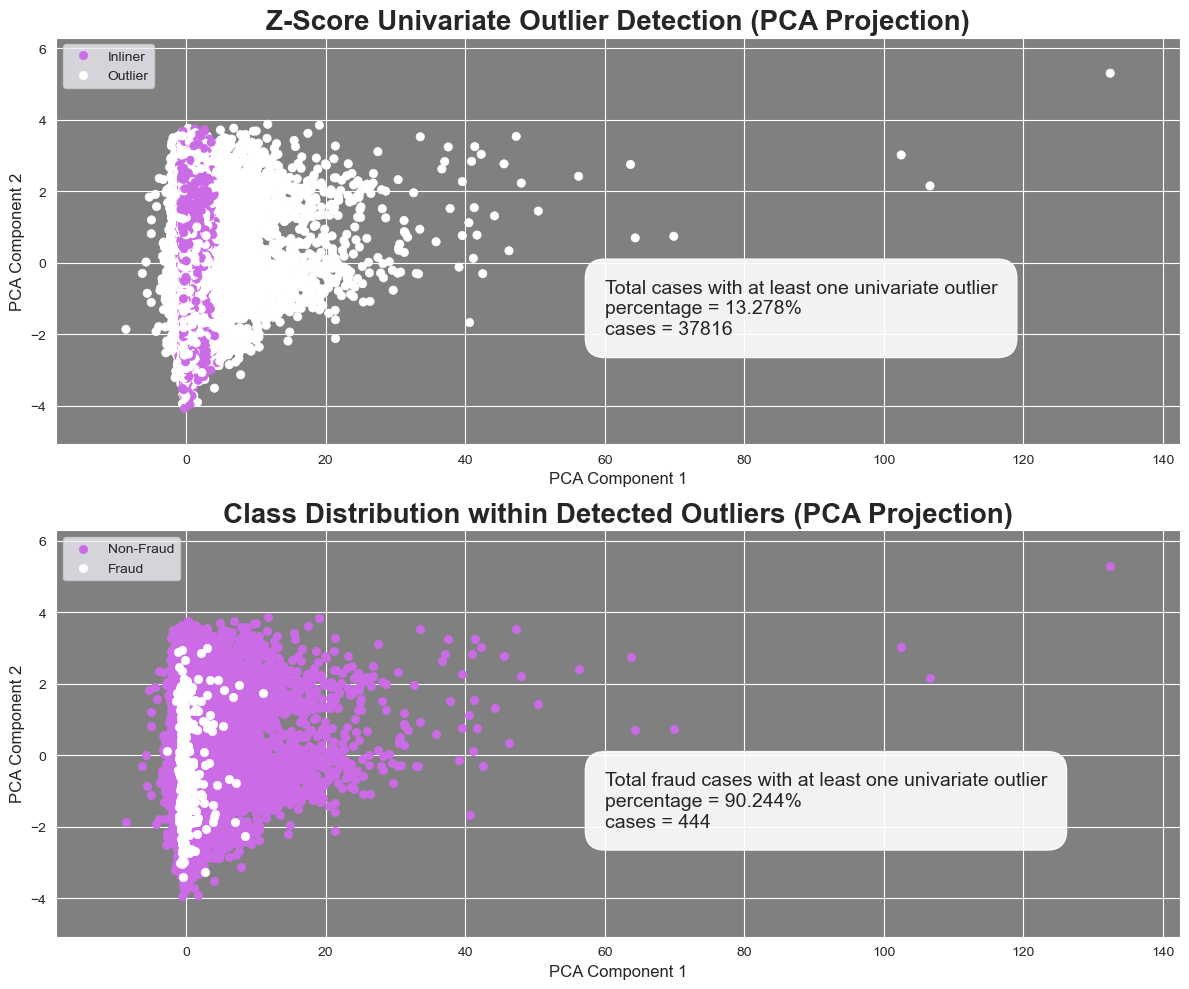

In [26]:
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

x, y = dfpca['PCA 1'], dfpca['PCA 2']
hue = ['Outlier' if val == 1 else 'Inliner' for val in zscore['Outlier']]
outliers = dfpca[dfpca['Outlier'] == 1].reset_index(drop=True)
nonfraud, fraud = outliers[outliers["Class"] == 0].reset_index(drop=True), outliers[outliers["Class"] == 1].reset_index(drop=True)

sns.scatterplot(x=x, y=y, edgecolor=None, hue=hue, palette=['#CB6CE6', 'white'], ax=axs[0])

outp0 = zscore[zscore['Outlier'] == 1].shape[0] / data.shape[0] * 100
str = f'Total cases with at least one univariate outlier\npercentage = {outp0:.3f}%\ncases = {len(outliers)}'
axs[0].text(60, -2, str, fontsize=14, bbox=dict(facecolor='white', alpha=0.9, edgecolor='w', boxstyle='round,pad=1'))

axs[0].set_xlim(min(x - 10), max(x + 10)), axs[0].set_ylim(min(y - 1), max(y + 1)), axs[0].set_facecolor('grey'), axs[0].grid()
axs[0].set_xlabel('PCA Component 1', fontsize=12), axs[0].set_ylabel('PCA Component 2', fontsize=12), axs[0].legend()
axs[0].set_title('Z-Score Univariate Outlier Detection (PCA Projection)', fontsize=20, fontweight='bold')

sns.scatterplot(x=nonfraud['PCA 1'], y=nonfraud['PCA 2'], edgecolor=None, color='#CB6CE6', label='Non-Fraud', ax=axs[1])
sns.scatterplot(x=fraud['PCA 1'], y=fraud['PCA 2'], edgecolor=None, color='white', label='Fraud', ax=axs[1])

outp1 = outliers[outliers['Class'] == 1].shape[0] / data1.shape[0] * 100
str = f'Total fraud cases with at least one univariate outlier\npercentage = {outp1:.3f}%\ncases = {len(outliers[outliers["Class"] == 1])}'
axs[1].text(60, -2, str, fontsize=14, bbox=dict(facecolor='white', alpha=0.9, edgecolor='w', boxstyle='round, pad=1'))

axs[1].set_xlim(min(x - 10), max(x + 10)), axs[1].set_ylim(min(y - 1), max(y + 1)), axs[1].set_facecolor('grey'), axs[1].grid()
axs[1].set_xlabel('PCA Component 1', fontsize=12), axs[1].set_ylabel('PCA Component 2', fontsize=12), axs[1].legend()
axs[1].set_title('Class Distribution within Detected Outliers (PCA Projection)', fontsize=20, fontweight='bold')
plt.tight_layout();

**"Z-Score Univariate Outlier Detection (PCA Projection)":** Este gráfico presenta los puntos clasificados como inliers (rosados) y outliers (blancos) utilizando un enfoque univariado (por ejemplo, basado en el z-score) y proyectados en un espacio reducido de dos componentes principales (PCA). Se observa que: Estos outliers están distribuidos a lo largo de la dimensión principal y no se concentran en una región particular del espacio proyectado, lo que sugiere que los outliers univariados pueden surgir en cualquier parte del dominio de los datos multivariados.

**"Class Distribution within Detected Outliers (PCA Projection)":** Aquí se visualiza cómo se distribuyen las clases dentro del conjunto de outliers univariados: El resultado muestra que el 90.244% de los casos de fraude presentan al menos una variable atípica, lo cual implica que la mayoría de los fraudes detectados tienen alguna anomalía univariada. Sin embargo, también hay una gran cantidad de transacciones legítimas (non-fraud) que presentan al menos una característica fuera del rango típico.

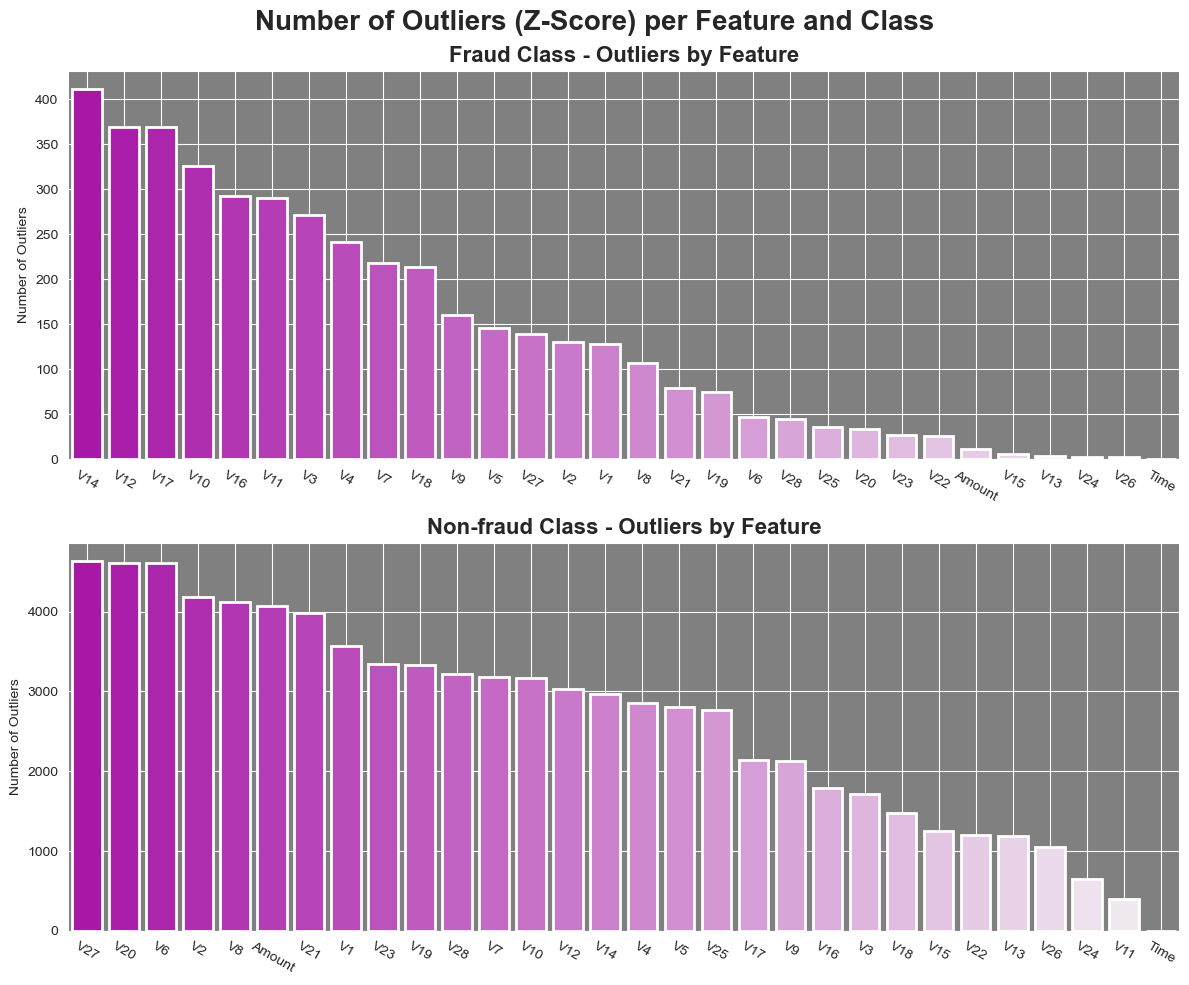

In [28]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12, 10))

test1 = zscore[(zscore['Class'] == 1) & (zscore['Outlier'] == 1)].reset_index(drop=True)
test1 = test1.drop(['Class', 'Outlier'], axis=1)
test1.columns = test1.columns.str.replace(' (Z-Score)', '', regex=False)

fraudcounts = {}
for col in test1.columns:
    count = ((test1[col] > 3) | (test1[col] < -3)).sum()
    fraudcounts[col] = count
fraudcounts = dict(sorted(fraudcounts.items(), key=lambda item: item[1], reverse=True))

sns.barplot(x=list(fraudcounts.keys()), y=list(fraudcounts.values()),
            palette='light:m_r', edgecolor='white', linewidth=2, ax=ax1)
ax1.tick_params(axis='x', rotation=-30), ax1.set_facecolor('grey'), ax1.grid()
ax1.set_xlabel(None), ax1.set_ylabel('Number of Outliers')
ax1.set_title('Fraud Class - Outliers by Feature', fontsize=16, fontweight='bold')


test0 = zscore[(zscore['Class'] == 0) & (zscore['Outlier'] == 1)].reset_index(drop=True)
test0 = test0.drop(['Class', 'Outlier'], axis=1)
test0.columns = test0.columns.str.replace(' (Z-Score)', '', regex=False)

nonfraudcounts = {}
for col in test0.columns:
    count = ((test0[col] > 3) | (test0[col] < -3)).sum()
    nonfraudcounts[col] = count
nonfraudcounts = dict(sorted(nonfraudcounts.items(), key=lambda item: item[1], reverse=True))

sns.barplot(x=list(nonfraudcounts.keys()), y=list(nonfraudcounts.values()),
            palette='light:m_r', edgecolor='white', linewidth=2, ax=ax2)
ax2.tick_params(axis='x', rotation=-30), ax2.set_facecolor('grey'), ax2.grid()
ax2.set_xlabel(None), ax2.set_ylabel('Number of Outliers')
ax2.set_title('Non-fraud Class - Outliers by Feature', fontsize=16, fontweight='bold')

fig.suptitle('Number of Outliers (Z-Score) per Feature and Class', fontsize=20, fontweight='bold')
plt.tight_layout();

Los gráficos muestran el número de outliers univariados (detectados mediante Z-score) por característica, diferenciando entre transacciones fraudulentas y no fraudulentas. En la clase de fraude, se observa una fuerte concentración de valores atípicos en variables como V14, V2, V17, V10, V16, V7 y V3, lo que indica que estas dimensiones presentan un comportamiento anómalo pronunciado en presencia de fraude. Este patrón respalda la idea de que el fraude tiende a manifestarse como una desviación significativa respecto al comportamiento estadístico normal de ciertas variables clave. Al cruzar esta observación con el análisis de correlación, se confirma que varias de estas variables con altos conteos de outliers también son las más correlacionadas con la variable objetivo, lo que sugiere que los valores extremos no solo son comunes en transacciones fraudulentas, sino que además son altamente informativos para distinguir entre clases. En contraste, en la clase no fraudulenta también existen variables con una gran cantidad de outliers, aunque el patrón es diferente y más distribuido entre variables que no muestran tanta correlación con la etiqueta. Esto refuerza la necesidad de no asumir que todo outlier implica fraude, pero sí que muchos fraudes implican outliers en variables específicas. En conjunto, estos gráficos revelan que la anomalía estadística en variables altamente correlacionadas puede ser una señal útil para la detección de fraude.

##### 6. MULTIVARIATE OUTLIER DETECTION VIA MAHALANOBIS DISTANCE

In [31]:
Xzscore  = zscore.drop('Class', axis=1)
center = Xzscore.mean()
cov = np.cov(Xzscore.T)
invcov = np.linalg.inv(cov)
zscore['Mahal'] = Xzscore.apply(lambda x: spatial.distance.mahalanobis(x, center, invcov), axis=1)

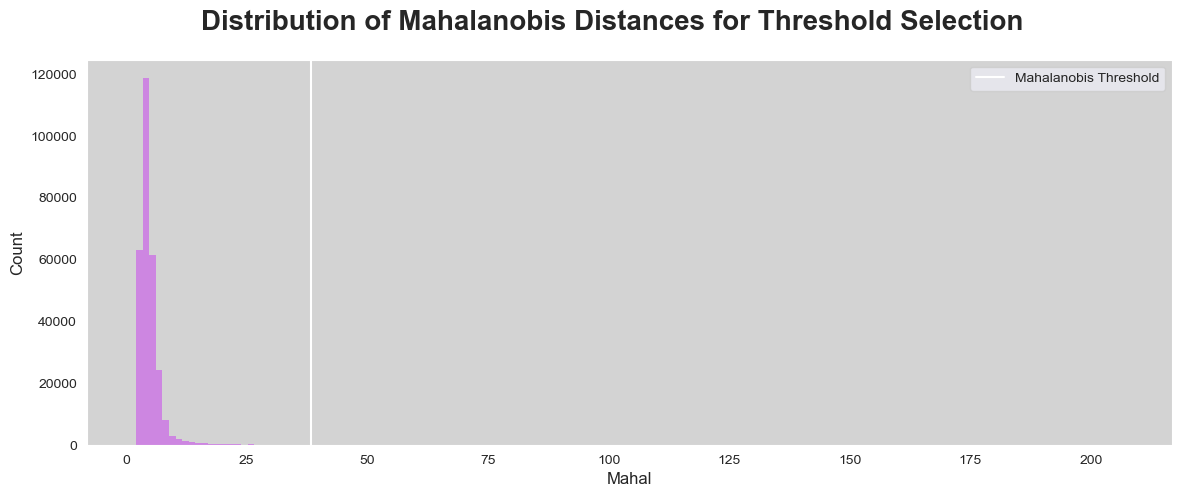

In [32]:
fig, ax = plt.subplots(figsize=(14, 5))
threshold = np.percentile(zscore['Mahal'], 99.9)

sns.histplot(zscore['Mahal'], bins=150, edgecolor='none', color='#CB6CE6')
plt.axvline(threshold, color='w', label='Mahalanobis Threshold')

plt.xlabel('Mahal', fontsize=12), plt.ylabel('Count', fontsize=12), ax.set_facecolor('lightgrey'), plt.legend()
plt.suptitle('Distribution of Mahalanobis Distances for Threshold Selection', fontsize=20, fontweight='bold')
plt.show()

In [33]:
zscore['Outlier'] = (zscore['Mahal'] > threshold).astype(int)
dfpca = pd.DataFrame(pca.fit_transform(Xzscore), columns=['PCA 1', 'PCA 2'])

dfpca['Outlier'] = zscore['Outlier'].values
dfpca['Class'] = data['Class'].values

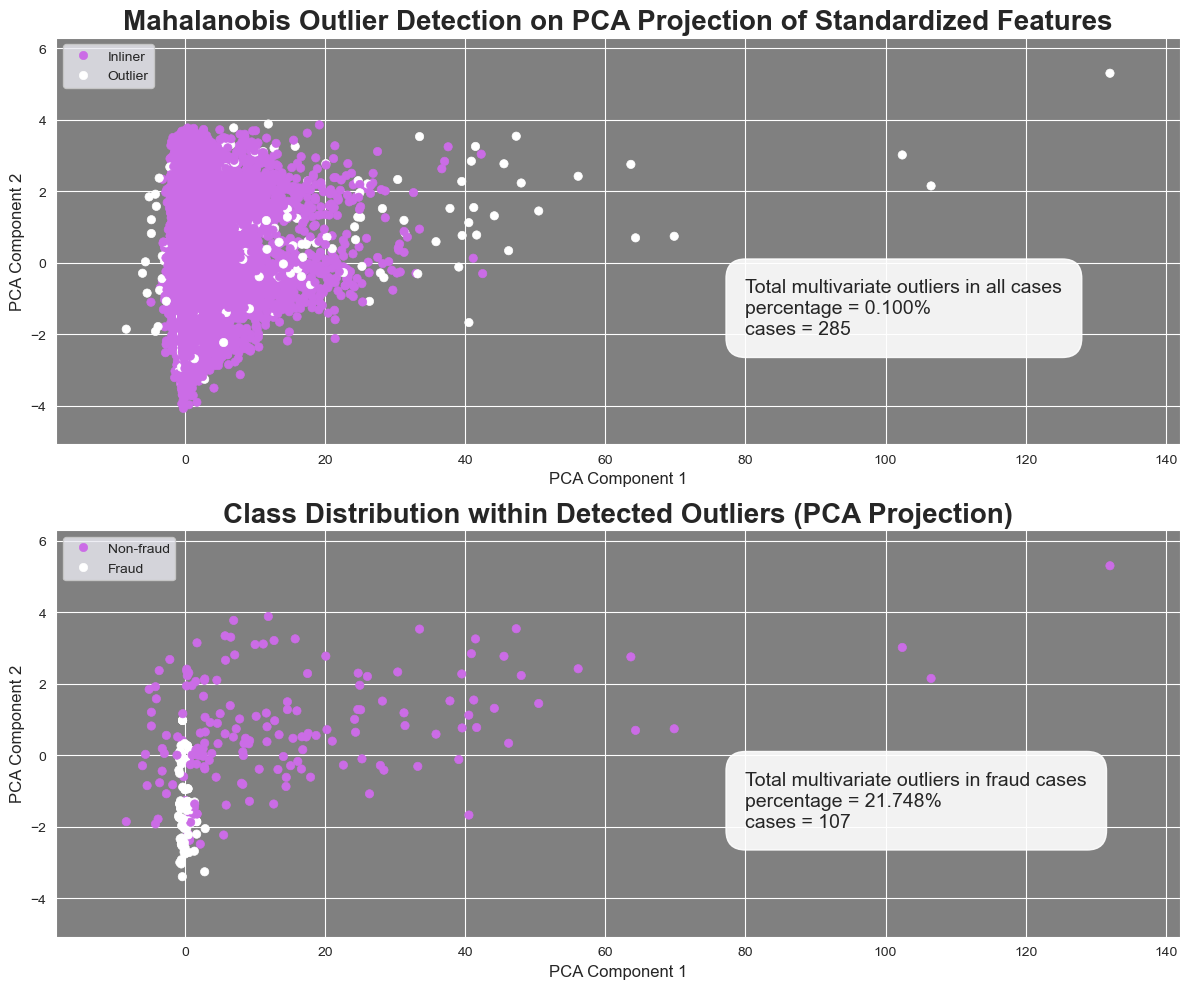

In [34]:
fig, axs = plt.subplots(2, 1, figsize=(12, 10))

x0, y0 = dfpca['PCA 1'], dfpca['PCA 2']
hue0 = ['Outlier' if val == 1 else 'Inliner' for val in dfpca['Outlier']]
outliers = dfpca[dfpca['Outlier'] == 1]

#PLOT 1
sns.scatterplot(x=x0, y=y0, edgecolor=None, hue=hue0, palette=['#CB6CE6', 'white'], ax=axs[0])

outp0 = outliers.shape[0] / data.shape[0] * 100
str = f'Total multivariate outliers in all cases\npercentage = {outp0:.3f}%\ncases = {len(outliers)}'
axs[0].text(80, -2, str, fontsize=14, bbox=dict(facecolor='white', alpha=0.9, edgecolor='w', boxstyle='round,pad=1'))

axs[0].set_xlim(min(x0 - 10), max(x0 + 10)), axs[0].set_ylim(min(y0 - 1), max(y0 + 1)), axs[0].set_facecolor('grey'), axs[0].grid()
axs[0].set_xlabel('PCA Component 1', fontsize=12), axs[0].set_ylabel('PCA Component 2', fontsize=12), axs[0].legend()
axs[0].set_title('Mahalanobis Outlier Detection on PCA Projection of Standardized Features', fontsize=20, fontweight='bold')

#PLOT 2
x1, y1 = outliers['PCA 1'], outliers['PCA 2']
hue1 = ['Fraud' if val == 1 else 'Non-fraud' for val in outliers['Class']]

sns.scatterplot(x=x1, y=y1, edgecolor=None, hue=hue1, palette=['#CB6CE6', 'white'], ax=axs[1])

outp1 = outliers[outliers['Class'] == 1].shape[0] / data1.shape[0] * 100
str = f'Total multivariate outliers in fraud cases\npercentage = {outp1:.3f}%\ncases = {len(outliers[outliers["Class"] == 1])}'
axs[1].text(80, -2, str, fontsize=14, bbox=dict(facecolor='white', alpha=0.9, edgecolor='w', boxstyle='round, pad=1'))

axs[1].set_xlim(min(x0 - 10), max(x0 + 10)), axs[1].set_ylim(min(y0 - 1), max(y0 + 1)), axs[1].set_facecolor('grey'), axs[1].grid()
axs[1].set_xlabel('PCA Component 1', fontsize=12), axs[1].set_ylabel('PCA Component 2', fontsize=12), axs[1].legend()
axs[1].set_title('Class Distribution within Detected Outliers (PCA Projection)', fontsize=20, fontweight='bold')
plt.tight_layout();

#### AUTOENCODER NETWORK

In [36]:
mms = preprocessing.MinMaxScaler(feature_range=(0, 1))

data0, data1 = data0.drop('Time', axis=1), data1.drop('Time', axis=1)

X0, y0 = data0.drop(columns='Class'), data0['Class'] ## Non-Fraud
X0train, X0test, y0train, y0test = model_selection.train_test_split(X0, y0, test_size=0.30, random_state=4)
X0test, X0val, y0test, y0val = model_selection.train_test_split(X0test, y0test, test_size=0.30, random_state=4)

X0train['Amount'], X0test['Amount'] = np.log1p(X0train['Amount']), np.log1p(X0test['Amount'])
X0train, X0test = mms.fit_transform(X0train), mms.transform(X0test)

X1, y1 = data1.drop(columns='Class'), data1['Class'] ## True Fraud
X1test, X1val, y1test, y1val = model_selection.train_test_split(X1, y1, test_size=0.30, random_state=4)

X1test['Amount'] = np.log1p(X1test['Amount'])
X1test = mms.transform(X1test)

In [37]:
np.random.seed(4), random.seed(4), tf.random.set_seed(4)

inputlayer = keras.layers.Input(shape=(X0train.shape[1],))

encoded = keras.layers.Dense(128, activation='tanh')(inputlayer)
encoded = keras.layers.Dropout(0.3)(encoded)
encoded = keras.layers.Dense(64, activation='tanh')(encoded)
encoded = keras.layers.Dropout(0.3)(encoded)

decoded = keras.layers.Dense(128, activation='tanh')(encoded)
decoded = keras.layers.Dense(64, activation='tanh')(decoded)

outputlayer = keras.layers.Dense(units=X0train.shape[1], activation='relu')(decoded)

autoencoder = keras.models.Model(inputlayer, outputlayer)

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X0train, X0train, epochs=25, batch_size=256, shuffle=True, validation_split=0.3, verbose=1)

Epoch 1/25
543/543 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0240 - val_loss: 9.6295e-04
Epoch 2/25
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0011 - val_loss: 3.6268e-04
Epoch 3/25
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6.9989e-04 - val_loss: 2.6084e-04
Epoch 4/25
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.8542e-04 - val_loss: 2.0293e-04
Epoch 5/25
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 5.1583e-04 - val_loss: 1.6009e-04
Epoch 6/25
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.7193e-04 - val_loss: 1.5155e-04
Epoch 7/25
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.5311e-04 - val_loss: 1.2945e-04
Epoch 8/25
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.4287e-04 - val_loss: 1.4289e-04
Epoch 9/25
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.3406e-04 - val_loss: 1.2259e-04
Epoch 10/25
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.3161e-04 - val_loss: 1.1265e-04
Epoch 11/25
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4.2635

#### AUTOENCODER RECONSTRUCTION & FEATURE ENGINEERING

In [39]:
Xreconstructed = autoencoder.predict(np.concatenate([X0test, X1test]))
Rerror = np.mean(np.square(np.concatenate([X0test, X1test]) - Xreconstructed), axis=1).reshape(-1,1)

Xmodel = np.concatenate([Xreconstructed, Rerror], axis=1)
ymodel = np.concatenate([y0test, y1test])

1870/1870 ━━━━━━━━━━━━━━━━━━━━ 1s 620us/step


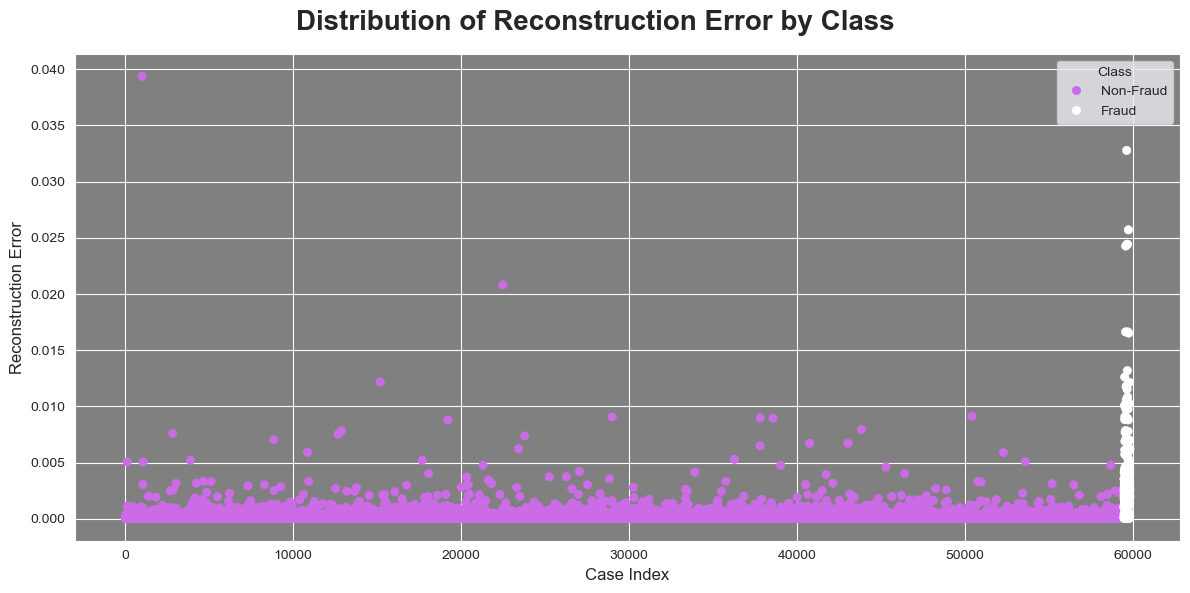

In [40]:
fig, ax = plt.subplots(figsize=(12, 6))
hue = np.where(ymodel == 1, 'Fraud', 'Non-Fraud')

sns.scatterplot(x=range(0, len(Xmodel)), y=Xmodel[:, -1], hue=hue,  palette=['#CB6CE6', 'white'], edgecolor=None)
plt.xlabel('Case Index', fontsize=12), plt.ylabel('Reconstruction Error', fontsize=12)
plt.suptitle('Distribution of Reconstruction Error by Class', fontsize=20, fontweight='bold')
ax.set_facecolor('grey'), plt.grid(), plt.legend(title='Class'), plt.tight_layout();

In [41]:
columns = list(data.columns.drop(['Time', 'Class']))
columns.append('R. Error')
datamodel = pd.DataFrame(Xmodel, columns=columns)
datamodel['Class'] = ymodel
datamodel0, datamodel1 = datamodel[datamodel['Class'] == 0], datamodel[datamodel['Class'] == 1]

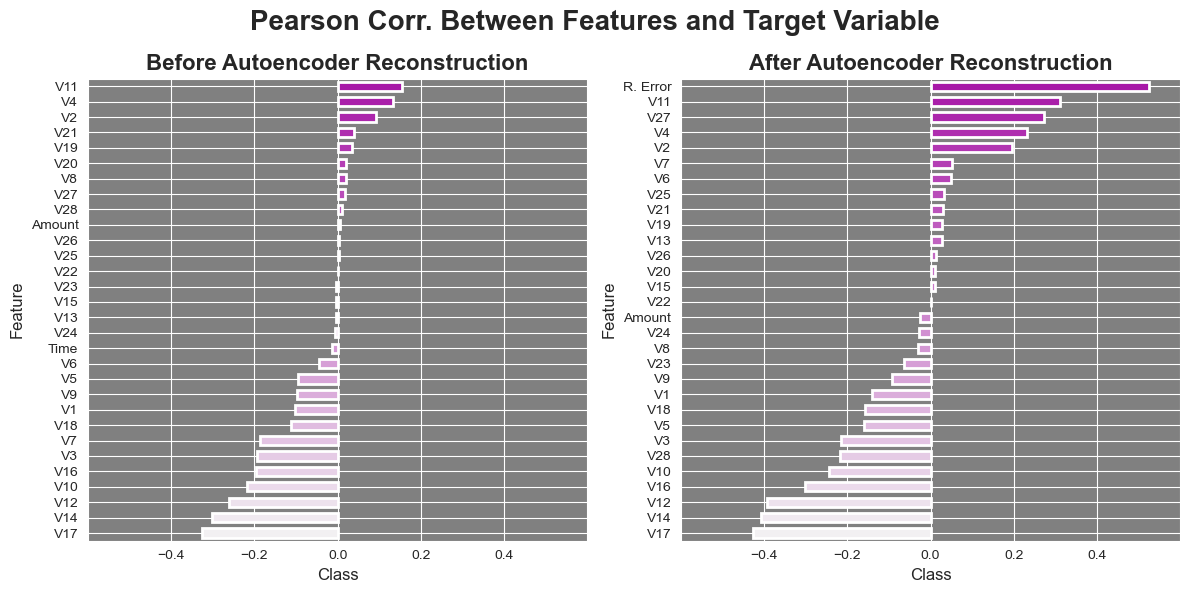

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
corr = data.corr()['Class'].drop('Class').sort_values(ascending=False).reset_index()

sns.barplot(data=corr, x='Class', y='index', width=0.6, palette='light:m_r', edgecolor='white', linewidth=2, ax=axs[0])

axs[0].set_xlabel('Class', fontsize=12), axs[0].set_ylabel('Feature', fontsize=12), axs[0].set_facecolor('grey'), axs[0].grid()
axs[0].set_xlim(-0.6, 0.6), axs[0].set_xticks([-0.4, -0.2, 0, 0.2, 0.4])
axs[0].set_title('Before Autoencoder Reconstruction', size=16, weight='bold')

corr = datamodel.corr()['Class'].drop('Class').sort_values(ascending=False).reset_index()

sns.barplot(data=corr, x='Class', y='index', width=0.6, palette='light:m_r', edgecolor='white', linewidth=2, ax=axs[1])

axs[1].set_xlabel('Class', fontsize=12), axs[1].set_ylabel('Feature', fontsize=12), axs[1].set_facecolor('grey'), axs[1].grid()
axs[1].set_title('After Autoencoder Reconstruction', size=16, weight='bold')
axs[1].set_xlim(-0.6, 0.6), axs[1].set_xticks([-0.4, -0.2, 0, 0.2, 0.4])
plt.suptitle('Pearson Corr. Between Features and Target Variable', size=20, weight='bold')
plt.tight_layout();

##### 1. 2-D DATA VISUALISATION (AFTER PREPROCESSING AND AUTOENCODER RECONSTRUCTION)

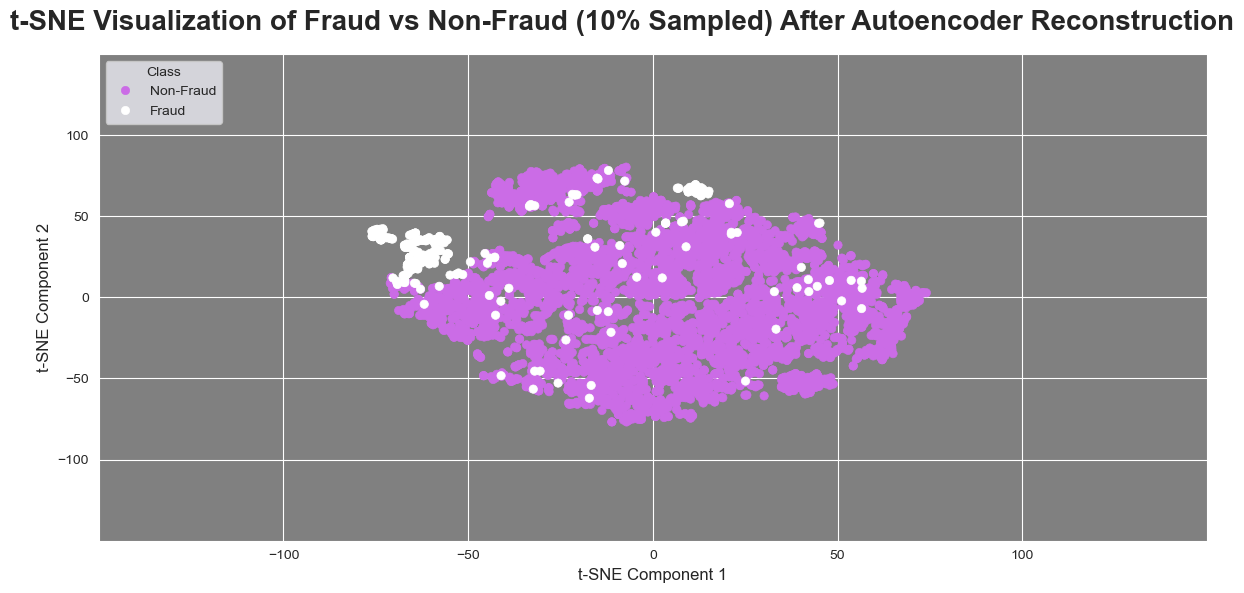

In [44]:
np.random.seed(4)

fig, ax = plt.subplots(figsize=(12, 6))

plotdata0 = datamodel0.iloc[np.random.choice(datamodel0.shape[0], int(len(datamodel0) * 0.10), replace=False)]
plotdata = pd.concat([plotdata0, datamodel1], axis=0).reset_index(drop=True)
Xsampled, ysampled = plotdata.drop(['Class'], axis=1).values, plotdata["Class"].values

tsneafter = tsne.fit_transform(Xsampled)
xtsneafter, ytsneafter = tsneafter[:,0], tsneafter[:,1]
hue = pd.Series(ysampled).replace({0:'Non-Fraud', 1:'Fraud'})

sns.scatterplot(x=xtsneafter, y=ytsneafter, hue=hue, palette=['#CB6CE6', 'white'], edgecolor=None)
plt.grid(), ax.set_facecolor('grey'), plt.legend(title='Class', loc='upper left')
plt.xlim(-150, 150), plt.xticks([-100, -50, 0, 50, 100]), plt.ylim(-150, 150), plt.yticks([-100, -50, 0, 50, 100])
plt.xlabel('t-SNE Component 1', fontsize=12), plt.ylabel('t-SNE Component 2', fontsize=12)
plt.suptitle('t-SNE Visualization of Fraud vs Non-Fraud (10% Sampled) After Autoencoder Reconstruction',
             fontsize=20, fontweight='bold'), plt.tight_layout();

#### RANDOM FOREST MODEL

In [46]:
kbest = 24
cv = model_selection.StratifiedKFold(n_splits=10, shuffle=True, random_state=4)

In [47]:
rfc = pipeline.Pipeline([('kbest', feature_selection.SelectKBest(score_func=feature_selection.mutual_info_classif, k=kbest)),
                          ('clf', ensemble.RandomForestClassifier(class_weight='balanced', max_depth=30, min_samples_split=10,
                                                                  n_estimators=300, n_jobs=-1, random_state=4))])

In [48]:
yprob_cv = model_selection.cross_val_predict(rfc, Xmodel, ymodel, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]

thresholds = np.linspace(0.1, 0.9, 80)
meanscores = []

for thresh in thresholds:
    ypred_thresh = (yprob_cv >= thresh).astype(int)
    score = metrics.average_precision_score(ymodel, ypred_thresh)
    meanscores.append(score)

bestthresh = thresholds[np.argmax(meanscores)]
print(f"Best Threshold = {bestthresh:.2f} with Average Precision = {max(meanscores):.4f}")

Best Threshold = 0.38 with Average Precision = 0.7871


In [49]:
display(rfc.fit(Xmodel, ymodel))

Pipeline(steps=[('kbest',
                 SelectKBest(k=24,
                             score_func=<function mutual_info_classif at 0x00000215C4EF7240>)),
                ('clf',
                 RandomForestClassifier(class_weight='balanced', max_depth=30,
                                        min_samples_split=10, n_estimators=300,
                                        n_jobs=-1, random_state=4))])

In [50]:
# DATA PIPELINE PROCESS
def pipeline_process(X):
    X['Amount'] = np.log1p(X['Amount'])
    Xfinal = mms.transform(X)  ## 1. MIN-MAX SCALER TRANSFORMATION
    Xrec = autoencoder.predict(Xfinal)  ## 2. AUTOENCODER NETWORK RECONSTRUCTION
    Rerror = np.mean(np.square(Xfinal - Xrec), axis=1).reshape(-1, 1)  ## 3. RECONSTRUCTION ERROR
    Xfinal = np.concatenate([Xrec, Rerror], axis=1) ## 4. FINAL DATA (AUTOENCODER OUTPUT + R. ERROR)
    
    return Xfinal ## THIS OUTPUT IS READY TO USE IN THE RANDOM FOREST CLASSIFIER MODEL

In [51]:
X, yfinal = pd.concat([X0val, X1val]), pd.concat([y0val, y1val]) ## CONCATENATE ONLY IN THIS CASE
Xfinal = pipeline_process(X)

802/802 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step


In [52]:
yprob = rfc.predict_proba(Xfinal)[:, 1]
ypred = (yprob >= bestthresh).astype(int)
clsrprt = metrics.classification_report(yfinal, ypred, output_dict=True)
report = pd.DataFrame(clsrprt).transpose()
report = report.style.set_table_attributes('style="margin-left: auto; margin-right: auto;"')
display(HTML("<h3 style='font-weight:bold;' >Random Forest Classifier Metrics (Trained and Tested with Autoencoder Reconstructed Data)</h3>"))
display(report)

,precision,recall,f1-score,support
0,0.999059,0.999725,0.999392,25493.000000
1,0.946565,0.837838,0.888889,148.000000
accuracy,0.998791,0.998791,0.998791,0.998791
macro avg,0.972812,0.918782,0.944141,25641.000000
weighted avg,0.998756,0.998791,0.998754,25641.000000


In [53]:
ymodelproba = model_selection.cross_val_predict(rfc, Xmodel, ymodel, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
auprc_train = metrics.average_precision_score(ymodel, ymodelproba) ## Calcula el AUPRC global
print('TRAIN DATA')
print(f"Average AUPRC: {auprc_train:.4f}")

yfinalproba = model_selection.cross_val_predict(rfc, Xfinal, yfinal, cv=cv, method='predict_proba', n_jobs=-1)[:, 1]
auprc_score = metrics.average_precision_score(yfinal, yfinalproba) ## Calcula el AUPRC global
print('TEST DATA')
print(f"Average AUPRC: {auprc_score:.4f}")

TRAIN DATA
Average AUPRC: 0.8673
TEST DATA
Average AUPRC: 0.8699


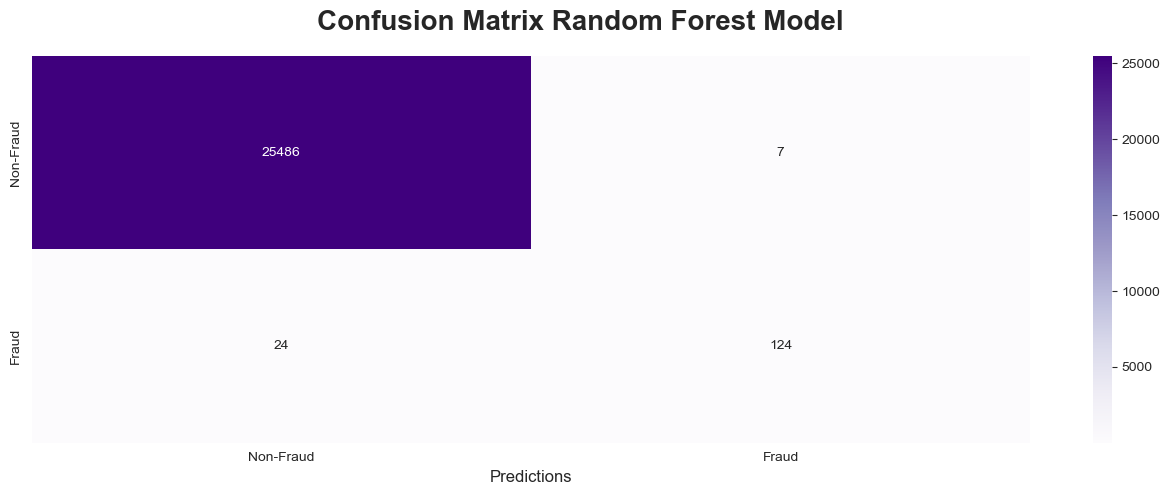

In [54]:
fig, ax = plt.subplots(figsize=(13, 5))
cm = metrics.confusion_matrix(yfinal, ypred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
plt.xlabel('Predictions', fontsize=12), plt.ylabel(None)
plt.suptitle('Confusion Matrix Random Forest Model', fontsize=20, fontweight='bold', x=0.45), plt.tight_layout();

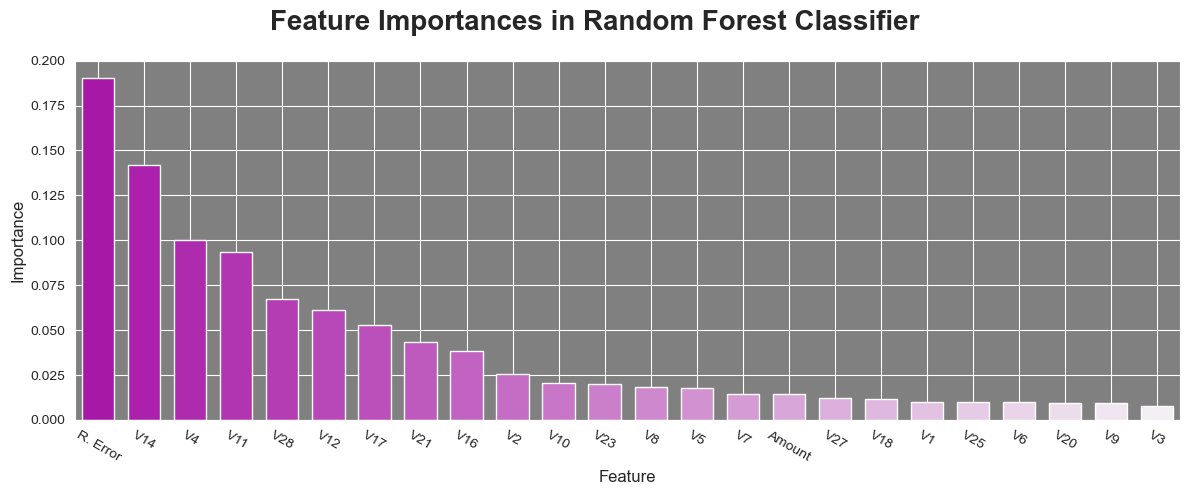

In [55]:
fig, ax = plt.subplots(figsize=(12, 5))
index = datamodel.drop(columns='Class').columns[rfc.named_steps['kbest'].get_support()]
importances = pd.DataFrame(data=rfc.named_steps['clf'].feature_importances_, columns=['Feature'], index=index)
importances = importances.reset_index().sort_values(by='Feature', ascending=False).reset_index(drop=True)

sns.barplot(data=importances, x='index', y='Feature', palette='light:m_r', width=0.7)
plt.xlabel('Feature', fontsize=12), plt.ylabel('Importance', fontsize=12)
plt.suptitle('Feature Importances in Random Forest Classifier', fontsize=20, fontweight='bold')
plt.xticks(rotation=-30), plt.grid(), ax.set_facecolor('grey'), plt.tight_layout();

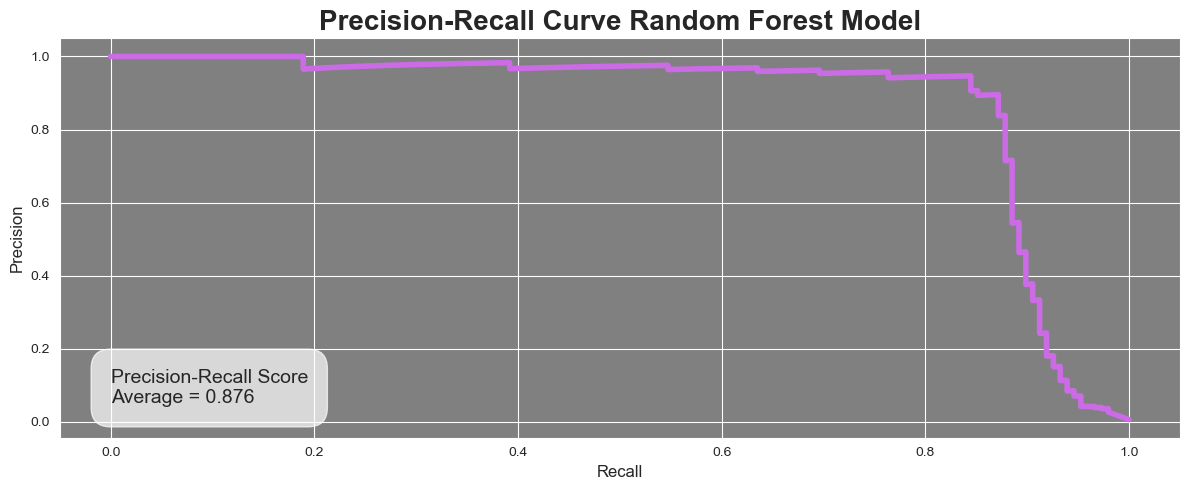

In [56]:
fig, ax = plt.subplots(figsize=(12, 5))
precision, recall, _ = metrics.precision_recall_curve(yfinal, yprob)
avgps = metrics.average_precision_score(yfinal, yprob)

ax.plot(recall, precision, color='#CB6CE6', linewidth=4)
str_text = f'Precision-Recall Score\nAverage = {avgps:.3f}'
ax.text(0, 0.05, str_text, fontsize=14, bbox=dict(facecolor='white', alpha=0.7, edgecolor='w', boxstyle='round,pad=1'))
ax.set_xlabel('Recall', fontsize=12), ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision-Recall Curve Random Forest Model', fontsize=20, fontweight='bold')
ax.set_facecolor('grey'), plt.grid(True), plt.tight_layout();

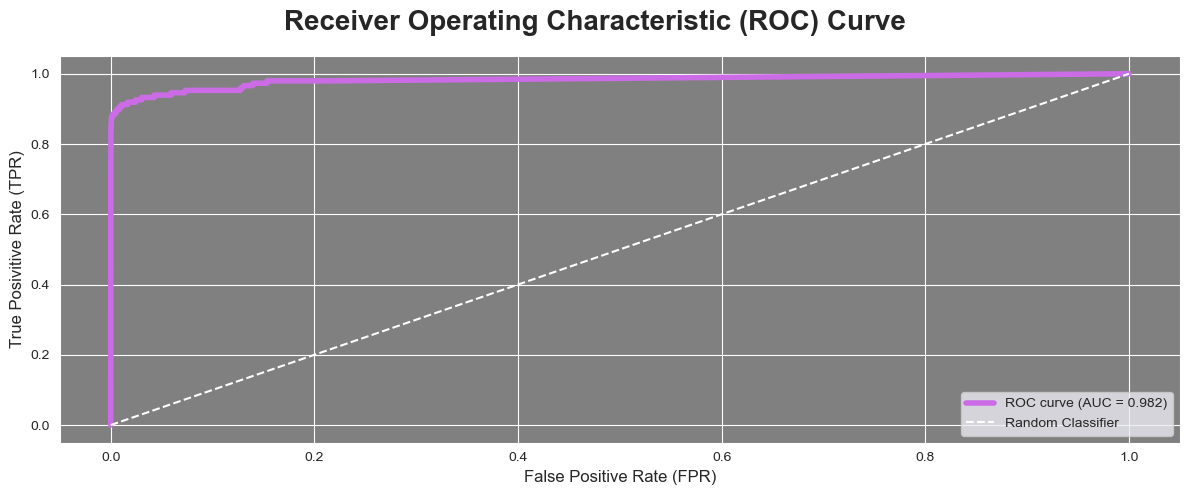

In [57]:
fig, ax = plt.subplots(figsize=(12, 5))

fpr, tpr, _ = metrics.roc_curve(yfinal, yprob)
roc_auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})', color='#CB6CE6', linewidth=4)
sns.lineplot(x=[0, 1], y=[0, 1], label='Random Classifier', color='white', linestyle='--')
plt.xlabel('False Positive Rate (FPR)', fontsize=12), plt.ylabel('True Posivitive Rate (TPR)', fontsize=12)
plt.suptitle('Receiver Operating Characteristic (ROC) Curve', fontsize=20, fontweight='bold')
plt.legend(loc='lower right'), ax.set_facecolor('grey'), plt.grid(), plt.tight_layout();

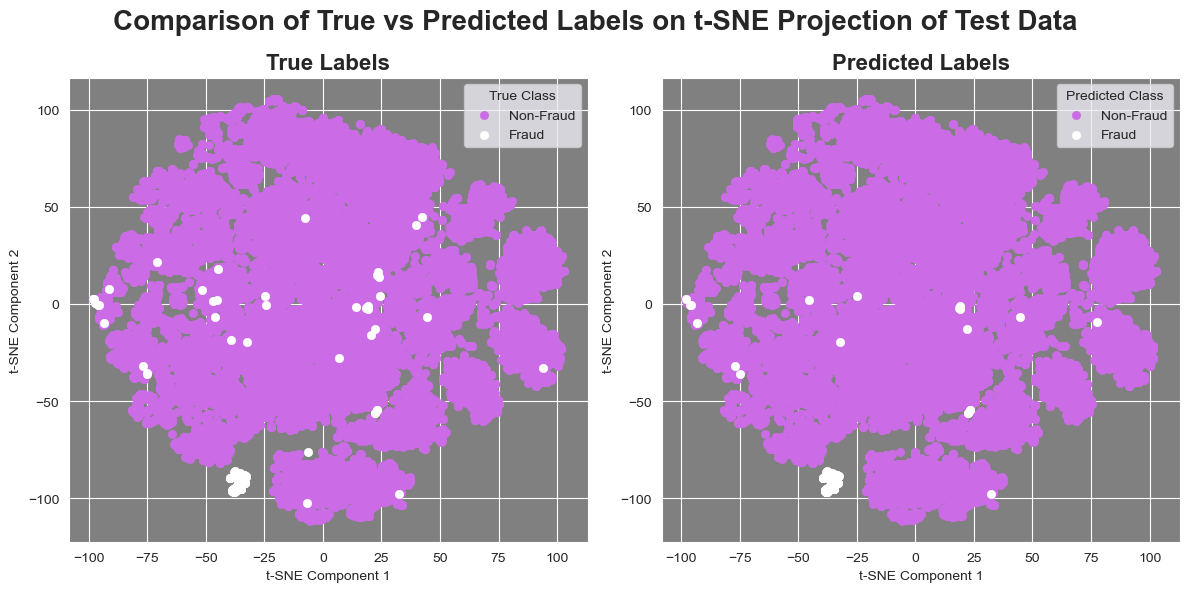

In [58]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
tsnedata = pd.DataFrame(tsne.fit_transform(Xfinal), columns=['t-SNE Component 1', 't-SNE Component 2'])
tsnedata['True'], tsnedata['Pred'] = yfinal.values, ypred
testtrue0, testtrue1 = tsnedata[tsnedata['True'] == 0], tsnedata[tsnedata['True'] == 1]
testpred0, testpred1 = tsnedata[tsnedata['Pred'] == 0], tsnedata[tsnedata['Pred'] == 1]

huefinal = pd.Series(yfinal).replace({0:'Non-Fraud', 1:'Fraud'})
sns.scatterplot(x=testtrue0['t-SNE Component 1'], y=testtrue0['t-SNE Component 2'], color='#CB6CE6', edgecolor=None, ax=axs[0], label='Non-Fraud')
sns.scatterplot(x=testtrue1['t-SNE Component 1'], y=testtrue1['t-SNE Component 2'], color='white', edgecolor=None, ax=axs[0], label='Fraud')
axs[0].set_title('True Labels', fontsize=16, fontweight='bold')
axs[0].set_facecolor('grey'), axs[0].grid(), axs[0].legend(title='True Class')

huepred = pd.Series(ypred).replace({0:'Non-Fraud', 1:'Fraud'})
sns.scatterplot(x=testpred0['t-SNE Component 1'], y=testpred0['t-SNE Component 2'], color='#CB6CE6', edgecolor=None, ax=axs[1], label='Non-Fraud')
sns.scatterplot(x=testpred1['t-SNE Component 1'], y=testpred1['t-SNE Component 2'], color='white', edgecolor=None, ax=axs[1], label='Fraud')
axs[1].set_title('Predicted Labels', fontsize=16, fontweight='bold')
axs[1].set_facecolor('grey'), axs[1].grid(), axs[1].legend(title='Predicted Class')

fig.suptitle('Comparison of True vs Predicted Labels on t-SNE Projection of Test Data', fontsize=20, fontweight='bold'), plt.tight_layout();